# Part 4 : Exploitation/exploration compromise

We consider a one dimensional world, with 8 possible positions, as defined in the
folder project/exercise_4. An agent lives in this world, and can perform one of 3
actions at each time step : stay at its position, move right or move left.
In this folder, you can find 3 files :


— simulation.py is the main file that you can run to evaluate a policy.
— agent.py defines the Agent class. This simple agent only has two attributes.
— position : its position
— known_rewards : represents the knowledge of the agent about the re-
wards in the worlds (see below)
— default_policy.py implements a default policy that consists in always going
left.


Some rewards are placed in this world randomly, and are randomly updated per-
diodically, at a fixed frequency. This means that a good agent should update its
policy periodically as well and adapt to the new rewards. The agent knows about
a reward in the world if its position has been on the same position as the reward,
but each time the rewards are updated, the agents forgets all this knowledge, as
implemented line 46 in simulation.py.


simulation.py computes the statistical amount of reward obtained by the agent
and plots the evolution of this quantity in images/. As you can see in the images/
folder, the average accumulated reward with the default policy is around 16, with a
little bit of variance.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sympy import symbols, Eq, solve
import random


WORLD_SIZE = 8
WORLD_UPDATE_PERIOD = 10
NB_PERIODS = int(2e3)
TOTAL_NUMBER_OF_STEPS = NB_PERIODS * WORLD_UPDATE_PERIOD
MAX_REWARD = 100
NB_REWARDS = 3

In [2]:
class Agent(object):

    """Docstring for Agent."""

    def __init__(self, initial_position, known_rewards) -> None:
        self.position = initial_position
        self.known_rewards = known_rewards

    def move(self, action, world_size) -> None:
        """
        the world is 1 dimensional
        """
        if action == "left":
            if self.position > 0:
                self.position -= 1
        elif action == "right":
            if self.position < world_size - 1:
                self.position += 1
        elif action == "none":
            pass
        else:
            raise ValueError("incorrect action")


In order to create our stochastic policy. We will use the Markov Decision Process.

The agent's environnement contain 8 case. So there is 8 States in total.

The agents can do only 3 Actions. Moving Left, Right or Stay where he is.

For each state the transition function can be represented by the probability of the agent successfully move into the desired state. For this exercise we can suppose that the probability law is a normal distribution. The desired state represent the standard deviation around the mean area(80%) and the others state reprensents the percentile away from the mean (10%).

The graph below is just an example and do not fully represent our distribution.

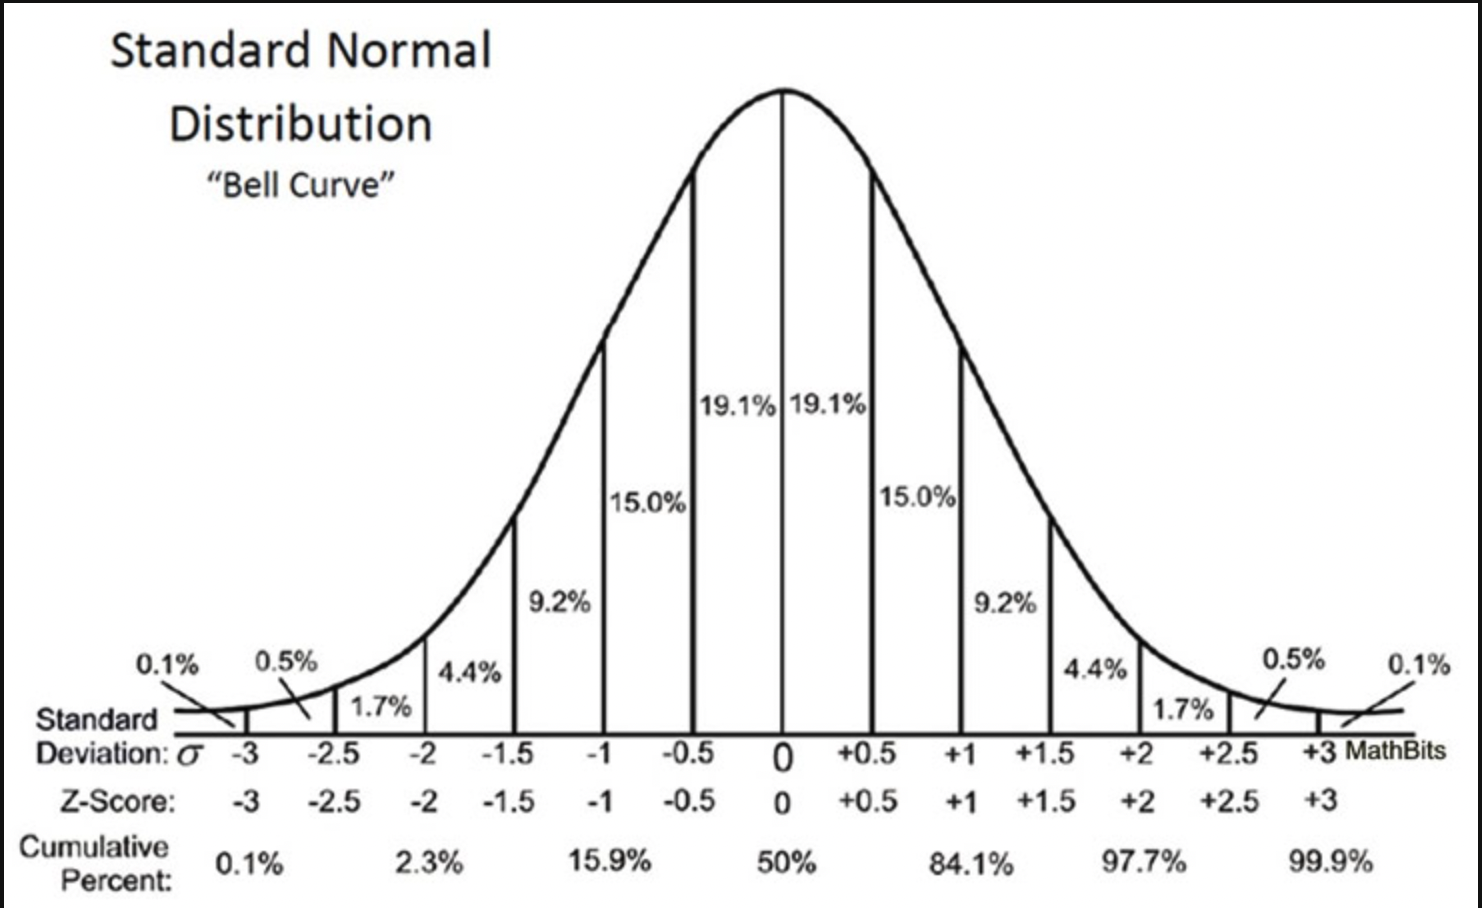

In [3]:
from IPython.display import Image
pil_img = Image(filename='example_normal_distrib2.png')
display(pil_img)

Transition(DesiredState) = 0.8

Transition(OtherState1) = 0.1

Transition(OtherState2) = 0.1

The reward function can be represented as the number of reward present in a state known by the agent. 

The value function is a variant of the Bellman Equation that can be represented as the sum of the Transition function * ( Reward function) for each possible successor state. The result beeing multiplied by a discount factor.

Our policy consist of make the agent move around randomly. When the agent have at least 2 known reward he will go into the direction of the most profitable reward and stay in place.

So we use a value matrix, created and solved by a system of linear equation. Each linear equation represent a state in the environnement.

In [4]:

#Rajouter des explications
def default_policy(agent: Agent) -> str:
    """
    Policy of the agent
    return "left", "right", or "none"
    """
    actions = ["left", "right", "none"]
    action = ""
    arrayEquation  = []
    discountFactor = 0.5
    arrayUnknown = [ chr(i + 97) for i in range(len(agent.known_rewards))]
    arraySymbols = [symbols(arrayUnknown[i]) for i in range(len(agent.known_rewards))]
    for i in range (WORLD_SIZE):
        a, b, c = 0, 0, 0
        a = 0.8 * (arraySymbols[i] + agent.known_rewards[i])
        if (i > 0):
            b = 0.1 * (agent.known_rewards[i - 1] +  arraySymbols[i - 1])
        if (i < WORLD_SIZE - 1):
            c = 0.1 * (agent.known_rewards[i + 1] + arraySymbols[i + 1])
        arrayEquation.append(Eq(((discountFactor * ( (a) + (b) + (c) ))), arraySymbols[i]))
    solution = solve(arrayEquation, arraySymbols)
    
    con_arr = np.array(list(solution.items()))
    final = np.array(con_arr[:,1])
    posMaxReward = np.argmax(final) # We retrieve the best value
    tmp = np.where(final > 0)[0] # We retrieve the rewards already visited

    if (len(tmp) < 2):
        posMaxReward = random.randint(0, len(agent.known_rewards))
    if agent.position < posMaxReward: # We set the action based on the direction
        action = "right"
    elif agent.position > posMaxReward:
        action = "left"
    else:
        action = "none"
    assert action in actions
    return action


In [ ]:



def reset_rewards(world_size: int) -> np.ndarray:
    rewards = np.zeros(world_size)
    for _ in range(NB_REWARDS):
        reward = np.random.randint(MAX_REWARD)
        position = np.random.randint(world_size)
        rewards[position] = reward
    return rewards


def run_simulation() -> list:
    rewards = reset_rewards(WORLD_SIZE)

    # initially, the agent does not know
    # the rewards distribution and the rewards
    # that are known to the agent are set to 0
    known_rewards = np.zeros(WORLD_SIZE)
    initial_position = int(WORLD_SIZE / 2)
    agent = Agent(initial_position, known_rewards)
    accumulated_reward = 0
    averaged_rewards = list()

    for step in range(TOTAL_NUMBER_OF_STEPS):

        # update world periodically
        # when the world is updated, the agent knows nothing
        # about the rewards anymore
        if step % (WORLD_UPDATE_PERIOD) == 0:
            rewards = reset_rewards(WORLD_SIZE)
            agent.known_rewards = np.zeros(WORLD_SIZE)
            # print("\n---\nreset the rewards\n---")
            # print(f"rewards: {rewards}\n")

        # choose action and move agent
        action = default_policy(agent)
        agent.move(action, WORLD_SIZE)
        # print(f"move {action}")
        # print(f"position: {agent.position}")

        # get reward
        reward = rewards[agent.position]
        agent.known_rewards[agent.position] = reward
        # print(f"found reward {reward}")
        # print(f"known rewards: {agent.known_rewards}\n")

        # update and average the obtained rewards
        accumulated_reward += reward
        averaged_reward = accumulated_reward / (step + 1)
        averaged_rewards.append(averaged_reward)
    return averaged_rewards


def main():
    averaged_rewards = run_simulation()
    final_averaged_reward = averaged_rewards[-1]
    print(f"final reward: {final_averaged_reward:.3f}")
    plt.plot(range(TOTAL_NUMBER_OF_STEPS), averaged_rewards, "o", markersize=1)
    plt.xlabel("simulation steps")
    plt.ylabel("accumulated reward")
    plt.ylim([-0.1 * final_averaged_reward, 2.1 * final_averaged_reward])
    title = (
        f"Averaged accumulated reward\n" f"averaged reward: {final_averaged_reward:.3f}"
    )
    plt.title(title)
    figname = f"{final_averaged_reward:.3f}.pdf"
    figpath = os.path.join("images", figname)
    plt.savefig(figpath)
    plt.close()


def clean(folder: str) -> None:
    for filename in os.listdir(folder):
        os.remove(os.path.join(folder, filename))


if __name__ == "__main__":
    main()


In [ ]:
final = np.array([0, 2, 0, 5])
tmp = np.where(final > 0)
print(tmp)
print(len(tmp[0]))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=78fee1a8-8fdd-4237-ba69-e565ec384717' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>